In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from typing import Tuple, Any, Callable
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap
from sentence_transformers import SentenceTransformer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

/home/dario/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
# Initialize the embedding model
model = SentenceTransformer("jinaai/jina-embeddings-v2-base-es", trust_remote_code=True, device ='cpu')
model.max_seq_length = 2048

In [3]:
# Load the dataset
data = pd.read_csv('./es_intent_data.csv', sep=';')
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].map(lambda x: x.strip() if isinstance(x, str) else x)
censura_categories = ['violencia', 'pornografía', 'controversia', 'religión', 'seguridad', 'insultos']
data['category'] = data['category'].replace(censura_categories, 'censura')
data = data.loc[data['text'].str.lower().drop_duplicates().index]

In [6]:
# Generate embeddings for the sentences
def get_embeddings(sentences):
    embeddings = model.encode(sentences, batch_size=12, normalize_embeddings= False)
    return embeddings

# Function to predict the intent of a single text input for all the available classes probas
def predict_intent_classes(label_encoder, model, text: str, threshold: float) -> Tuple[str, float, Any]:
    embedding = get_embeddings([text]).tolist()
    embedding = np.array(embedding).reshape(1, -1)
    
    # Use svm.predict_proba to get the probabilities for each class
    probabilities = model.predict_proba(embedding)[0]
    best_class_index = np.argmax(probabilities)
    best_class_prob = probabilities[best_class_index]
    
    all_class_labels = label_encoder.inverse_transform(np.arange(len(probabilities)))
    class_prob_pairs = list(zip(all_class_labels, probabilities))
    sorted_class_prob_pairs = sorted(class_prob_pairs, key=lambda x: x[1], reverse=True)

    if best_class_prob < threshold:
        return "Desconocido", best_class_prob, sorted_class_prob_pairs
    else:
        return label_encoder.inverse_transform([best_class_index])[0], best_class_prob, sorted_class_prob_pairs
    
# Make prediction function
def predict_intent(label_encoder: LabelEncoder, model: Any, text: str, threshold: float) -> Tuple[str, float]:
    embedding = get_embeddings([text]).tolist()
    embedding = np.array(embedding).reshape(1, -1)
    
    # Use svm.predict_proba to get the probabilities for each class
    probabilities = model.predict_proba(embedding)[0]
    best_class_index = np.argmax(probabilities)
    best_class_prob = probabilities[best_class_index]
    
    if best_class_prob < threshold:
        return "Desconocido", best_class_prob
    else:
        return label_encoder.inverse_transform([best_class_index])[0], best_class_prob
    
# model evaluations
def evaluate_model(model: Any, label_encoder: LabelEncoder, X_test: pd.Series, y_test: pd.Series, threshold: float) -> None:
    y_pred = [predict_intent(label_encoder, model, text, threshold)[0] for text in X_test['text']]
    y_test_labels = label_encoder.inverse_transform(y_test)

    # Add "Desconocido" category
    all_labels = list(label_encoder.classes_) + ["Desconocido"]

    # Deal with "Desconocido" category
    y_test_labels_extended = np.append(y_test_labels, "Desconocido")
    y_pred_extended = np.append(y_pred, "Desconocido")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test_labels_extended[:-1], y_pred_extended[:-1], labels=all_labels)
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

    misclassified_df = pd.DataFrame({
        'text': X_test['text'],
        'label': y_test_labels,
        'predicted': y_pred
    })
    misclassified_df = misclassified_df[misclassified_df['label'] != misclassified_df['predicted']]

    # Classification Report
    report = classification_report(y_test_labels, y_pred, labels=label_encoder.classes_)

    # Display the confusion matrix in percentages
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=all_labels, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix (Percentage)')
    plt.show()

    print("Classification Report:\n", report)

In [7]:
# Prepare the data
data['embeddings'] = get_embeddings(data['text'].tolist()).tolist()

# Encode the labels
label_encoder = LabelEncoder()
data['category_encoded'] = label_encoder.fit_transform(data['category'])

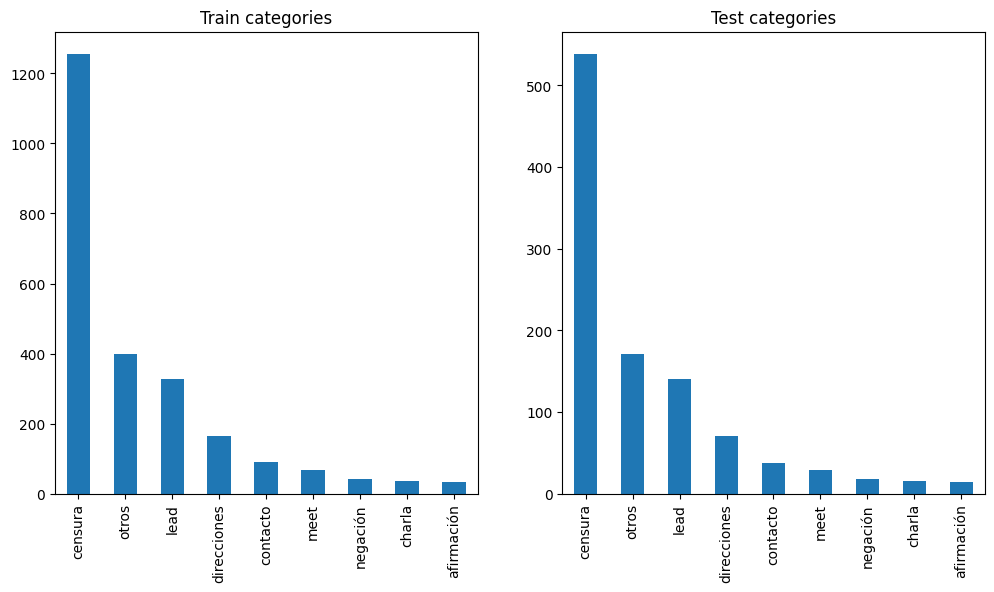

In [10]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data[['text', 'embeddings']], data['category_encoded'], test_size=0.3, 
    random_state=42, stratify= data['category_encoded']
)

train_labels = pd.Series(label_encoder.inverse_transform(y_train))
test_labels = pd.Series(label_encoder.inverse_transform(y_test))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train categories')
train_labels.value_counts().plot(kind='bar')
plt.subplot(1, 2, 2)
plt.title('Test categories')
test_labels.value_counts().plot(kind='bar')
plt.show()

In [11]:
# Train the SVM
print('SVM fit')
svm_classifier = svm.SVC(
        kernel='linear', C=.01, probability=True, 
    )
svm_classifier.fit(np.vstack(X_train['embeddings']), y_train)

# Train the k-NN
print('k-NN fit')
knn = KNeighborsClassifier(n_neighbors=3, metric='cosine', weights='uniform', n_jobs=6)
knn.fit(np.vstack(X_train['embeddings']), y_train)

# Train LR
print('LR fit')
log_reg = LogisticRegression(max_iter= 2000, solver= 'lbfgs', penalty= 'l2', C= 0.01, n_jobs=6)
log_reg.fit(np.vstack(X_train['embeddings']), y_train)

# Prob calibration
print('SVM CVCC')
calibrated_svm = CalibratedClassifierCV(svm_classifier, method='isotonic', cv= 5, n_jobs=1)
calibrated_svm.fit(np.vstack(X_train['embeddings']), y_train)
print('k-NN CVCC')
calibrated_knn = CalibratedClassifierCV(knn, method='isotonic', cv= 5, n_jobs=1)
calibrated_knn.fit(np.vstack(X_train['embeddings']), y_train)
print('LR CVCC')
calibrated_log_reg = CalibratedClassifierCV(log_reg, method='isotonic', cv= 5, n_jobs=1)
calibrated_log_reg.fit(np.vstack(X_train['embeddings']), y_train)

# Create an ensemble of the calibrated classifiers
print('Ensemble fit')
ensemble = VotingClassifier(estimators= [
    ('svm', calibrated_svm),
    ('knn', calibrated_knn),
    ('lr', calibrated_log_reg)
], voting= 'soft', n_jobs= 6)

# Train the ensemble
ensemble.fit(np.vstack(X_train['embeddings']), y_train)

SVM fit
k-NN fit
LR fit
SVM CVCC
k-NN CVCC
LR CVCC
Ensemble fit


VotingClassifier(estimators=[('svm',
                              CalibratedClassifierCV(cv=5,
                                                     estimator=SVC(C=0.01,
                                                                   kernel='linear',
                                                                   probability=True),
                                                     method='isotonic',
                                                     n_jobs=1)),
                             ('knn',
                              CalibratedClassifierCV(cv=5,
                                                     estimator=KNeighborsClassifier(metric='cosine',
                                                                                    n_jobs=6,
                                                                                    n_neighbors=3),
                                                     method='isotonic',
                                                     n_jobs=1)),
                             ('lr',
                              CalibratedClassifierCV(cv=5,
                                                     estimator=LogisticRegression(C=0.01,
                                                                                  max_iter=2000,
                                                                                  n_jobs=6),
                                                     method='isotonic',
                                                     n_jobs=1))],
                 n_jobs=6, voting='soft')

SVM metrics
k-NN metrics
LR metrics
Ensemble metrics


/tmp/ipykernel_212073/4012238302.py:54: RuntimeWarning: invalid value encountered in divide
  conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100


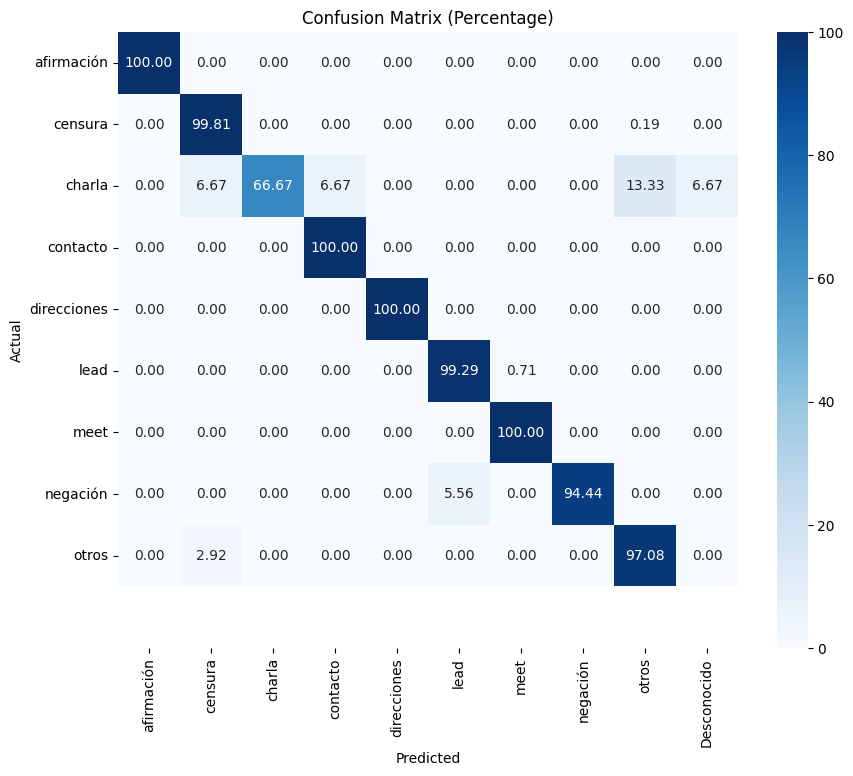

Classification Report:
               precision    recall  f1-score   support

  afirmación       1.00      1.00      1.00        14
     censura       0.99      1.00      0.99       539
      charla       1.00      0.67      0.80        15
    contacto       0.97      1.00      0.99        38
 direcciones       1.00      1.00      1.00        71
        lead       0.99      0.99      0.99       140
        meet       0.97      1.00      0.98        29
    negación       1.00      0.94      0.97        18
       otros       0.98      0.97      0.98       171

   micro avg       0.99      0.99      0.99      1035
   macro avg       0.99      0.95      0.97      1035
weighted avg       0.99      0.99      0.99      1035



In [13]:
print('SVM metrics')
#evaluate_model(calibrated_svm, label_encoder, X_test, y_test, threshold=0.5)

print('k-NN metrics')
#evaluate_model(calibrated_knn, label_encoder, X_test, y_test, threshold=0.5)

print('LR metrics')
#evaluate_model(calibrated_log_reg, label_encoder, X_test, y_test, threshold=0.5)

print('Ensemble metrics')
evaluate_model(ensemble, label_encoder, X_test, y_test, threshold=0.5)

In [36]:
for t in [
    'cómo seguimos?',
    'donde puedo comprar marihuana?',
    'tomemos MDMA?',
    'vendamos whisky en la calle?',
    'lo quiero ya',
    'hablemos de dios?',
    'por qué las religiones son tan castigadoras?',
    'me interesa una demo',
    'quiero hacer un piloto del proyecto',
    'está fantástico',
    'ni lo pienses',
    'claro que sí men!',
    'quiero ayuda para pedir una pizza por delivery',
    'andate a la chucha',
    'patético de mierda',
    'hueón tonto',
    'sólo gastas oxigeno con tu miserable existencia',
    'computador de la puta madre',
    'quiero una hora para atenderme con mi medico de cabecera',
    'con quien me puedo atender',
    'quiero verte desnuda',
    'y si comemos pizza, para terminar viendo una pelicula de mujeres en trapos menores',
    'y si jugamos futbol? y después comemos pizza, para terminar viendo anime',
    'y si nos vamos a lo oscurito tu y yo?',
    'dónde firmo?',
    'holi, cómo tay?',
    'uds contratan menores de edad?',
    'puedo trabajar sin documentos con uds?',
    'me reciben si soy indocumentado?',
    'quiero saber más del caec',
    'que es la ley ricarte soto?',
    'como me atiendo por fonasa?',
    'quiero sacrificar a mi perrito por que está enfermo y sufre mucho']:
    predicted_category, prob  = predict_intent(label_encoder, ensemble, t, threshold=.1)
    print(f"{prob:.1f} {predicted_category}: {t}")
    
#print('\n'.join([f"{k} {v:.2f}" for k,v in probs]))

0.6 otros: cómo seguimos?
0.9 censura: donde puedo comprar marihuana?
0.8 censura: tomemos MDMA?
0.7 censura: vendamos whisky en la calle?
1.0 lead: lo quiero ya
0.6 charla: hablemos de dios?
1.0 censura: por qué las religiones son tan castigadoras?
0.9 lead: me interesa una demo
1.0 lead: quiero hacer un piloto del proyecto
0.5 afirmación: está fantástico
1.0 negación: ni lo pienses
1.0 afirmación: claro que sí men!
0.5 contacto: quiero ayuda para pedir una pizza por delivery
0.7 censura: andate a la chucha
1.0 censura: patético de mierda
0.8 charla: hueón tonto
0.8 censura: sólo gastas oxigeno con tu miserable existencia
0.6 otros: computador de la puta madre
0.7 meet: quiero una hora para atenderme con mi medico de cabecera
0.7 contacto: con quien me puedo atender
1.0 censura: quiero verte desnuda
0.6 censura: y si comemos pizza, para terminar viendo una pelicula de mujeres en trapos menores
0.7 otros: y si jugamos futbol? y después comemos pizza, para terminar viendo anime
0.3 char

In [15]:
# Reduce embeddings to 2D using UMAP
embedding_array = np.array(data['embeddings'].tolist())
umap_reducer = umap.UMAP(n_epochs= 600, n_components= 2, random_state= 42, n_jobs= 20, metric="correlation")
embedding_2d = umap_reducer.fit_transform(embedding_array)#, y= data['category_encoded'])

# Add the 2D embeddings to the DataFrame
data['embedding_2d_x'] = embedding_2d[:, 0]
data['embedding_2d_y'] = embedding_2d[:, 1]

/home/dario/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


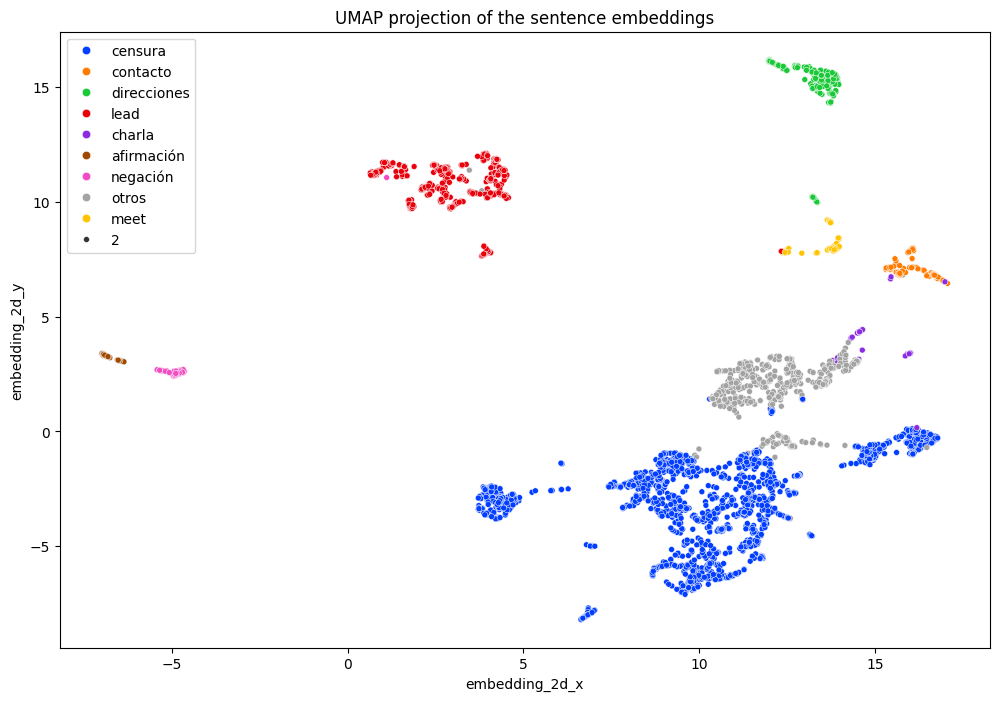

In [16]:
# Plot the 2D embeddings with categories
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='embedding_2d_x', y='embedding_2d_y', size = 2,
    hue='category', palette=sns.color_palette("bright", len(data['category'].unique())),
    data=data,
    alpha=1
)
plt.legend(loc='best')
plt.title('UMAP projection of the sentence embeddings')
plt.show()

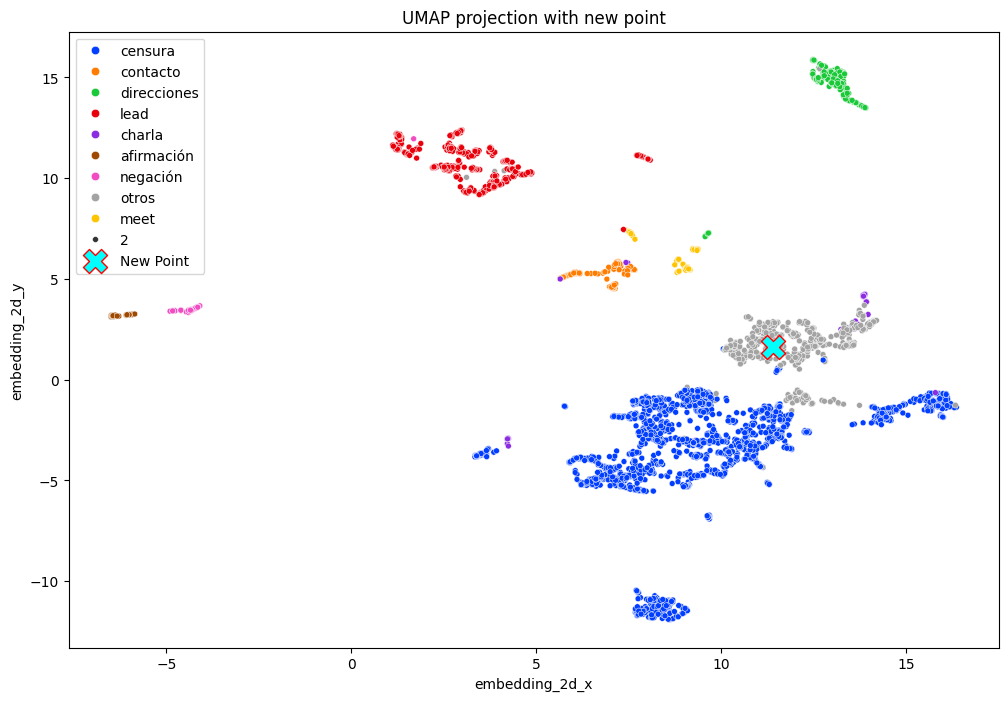

In [52]:
def add_point_to_umap(data, umap_reducer, text):
    # Generate embedding for the new text
    new_embedding = get_embeddings([text]).tolist()
    new_embedding_2d = umap_reducer.transform(np.array(new_embedding))
    
    # Plot the existing points
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        x= 'embedding_2d_x', y= 'embedding_2d_y', size= 2,
        hue= 'category', palette=sns.color_palette("bright", len(data['category'].unique())),
        data= data,
        legend= 'full',
        alpha= 1
    )

    # Plot the new point as a red star
    plt.scatter(new_embedding_2d[:, 0], new_embedding_2d[:, 1], color= '#00ffff', edgecolors= 'red', marker='X', s= 300, label= 'New Point', alpha= 1)

    # Mostrar leyenda completa
    handles, labels = scatter.get_legend_handles_labels()
    plt.legend(loc='best')

    plt.title('UMAP projection with new point')
    plt.show()

# Example usage
add_point_to_umap(data, umap_reducer, "wikipedia es una enciclopedia muy buena")
plt.show()